In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from edamame import *
from edamame.core.simulate import simCore
from edamame.analysis.InfoTheory import *
from tqdm.notebook import tqdm as tqdm
import pickle
import _pickle as cPickle
from dask.distributed import Client

In [25]:
import gzip

def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [3]:
useMyRC()
from matplotlib.colors import LogNorm

In [4]:
from scipy.io import loadmat

In [5]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [6]:
client = Client('127.0.0.1:58786')
client

In [7]:
dataLoc='/import/silo2/aloe8475/Documents/CODE/Analysis/Training/MNIST/data/'

In [8]:
pwd

'/import/silo2/aloe8475/Documents/CODE/Analysis/Training/MNIST'

In [14]:
#Load MNIST
data = loadmat(dataLoc+'mnist.mat')
#Noisy MNIST
ndata = loadmat(dataLoc+'mnist-with-awgn.mat')

In [26]:
#Load Networks:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_10sets_NWN.pkl'
NWN=decompress_pickle(name)

In [33]:
graph=NWN[0][-1]['G']

In [34]:
np.random.seed(18800)
n_train = 10000
n_test = 10000
n_im = n_train + n_test
# n_pix = n_im * 28**2
dt = 1

train_id = np.random.choice(range(60000), n_train, False)
# train_id = np.arange(10000)
test_id  = np.random.choice(range(10000), n_test, False)

trainX_raw  = data['trainX'][train_id]
# trainXT = np.transpose(trainX_raw.reshape(-1, 28, 28), (0,2,1))
trainY  = data['trainY'].reshape(-1)[train_id]

testX_raw   = data['testX'][test_id]
# testXT  = np.transpose(testX_raw.reshape(-1, 28, 28), (0,2,1))
testY   = data['testY'].reshape(-1)[test_id]

kdm = 5 #size of kernel
n_scan = (29-kdm)**2
n_row = 29-kdm

stream_raw = np.vstack((trainX_raw, testX_raw))
stream = np.zeros((n_im, (29-kdm)**2, kdm**2))
for i in tqdm(range(n_im)):
    stream[i,:] = kernel_scan(stream_raw[i].reshape(28,28), (kdm, kdm)).reshape(-1, kdm**2)
    
# a, b =4, -2
# signals = a/255 * stream.reshape(-1, kdm**2) + b
# length = signals.shape[0]

# Connectivity = connectivity__('500nw_9905junctions')
# Connectivity = connectivity__('200nw_1213junctions')
Connectivity = connectivity__(graph=NWN[0][-1]['G'])
electrodes = np.random.choice(range(Connectivity.numOfWires), kdm**2 + 1, False)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [24]:
def run_MNIST(con, kdm, electrodes, stream_in, j):
    a, b = 1, -0.3
    dt = 1 
    npc = stream_in.shape[0]
    
    signals = a/255 * stream_in.reshape(-1, kdm**2) + b
    length = signals.shape[0]
#     electrodes = np.random.choice(range(con.numOfWires), kdm**2 + 1, False)
    n_im = stream_in.shape[0]
    n_scan = (29-kdm)**2
    n_row = 29-kdm
    
    stimulus = []
    for i in range(kdm**2):
        stimulus.append(stimulus__('Custom', T = length*dt, dt = dt, 
                                   customSignal = signals[:,i]))
    
    sim = runSim(con, T = length*dt, 
                 lite_mode = True,
                 dt = dt, 
                 start_state = None,
                 stimulus = stimulus,
                 junctionMode = 'tunneling', 
                 contactMode = 'preSet', electrodes = electrodes,
                 findFirst=False, disable_tqdm=False)
    

    read = sim.electrodeCurrent[:,:-1].reshape(n_im, n_row, n_row, kdm**2)
    r0 = np.max(read, axis = 2).reshape(n_im, -1)
    r1 = np.max(read, axis = 1).reshape(n_im, -1)
#     return np.hstack((r0, r1))
    pkl_save(read, f'/project/NASN/rzhu/temp/k={kdm}_temp_{int(j/npc)}.pkl')
    return None
    

#     read = sim.electrodeCurrent[:,:-1].reshape(n_im, n_row, n_row, kdm, kdm)
#     return read[:,:,:,range(kdm), range(kdm)].reshape(n_im, -1)
#     read = sim.electrodeCurrent[:,:-1].reshape(n_im, n_row, n_row, kdm**2)
#     return np.max(read, axis = 2).reshape(n_im, -1)

In [25]:
def LDA_test(X, Y, test_X, test_Y, sub_sample = 1, return_map = False):
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    model = LDA(solver = 'lsqr', shrinkage = 'auto')
    model.fit(X[:,::sub_sample], Y)
    # result = model.predict(test_X[:,::sub_sample])
    acc = model.score(test_X, test_Y)
    if return_map:
        result = model.predict(test_X)
        sz = np.max(testY)+1
        fit_map = np.zeros((sz,sz))
        for i in range(len(result)):
            fit_map[testY[i], result[i]] += 1
        return acc, fit_map
    else:
        return acc

In [ ]:
npc = 50

init_list = [inputPacker(run_MNIST, Connectivity,kdm, electrodes, stream[i:i+npc], i) for i in range(0, n_im, npc)]
results = para_run(run_MNIST, init_list, dask_client = client, batch_size = 100, temp_path = '/project/NASN/rzhu/temp/')

In [15]:
results.shape

(12000, 1200)

In [27]:
# results = np.zeros((12000, 24*24*25))

kdm = 5
n_row = 29-kdm

for i in tqdm(range(int(n_im/npc))):
    temp = pkl_load(f'/project/NASN/rzhu/temp/k={kdm}_temp_{i}.pkl').reshape(npc, n_row, n_row, kdm, kdm)
    
    temp = temp.reshape(npc, n_row, n_row, kdm**2)
    haha = []
    for j in range(len(temp)):
        for k in range(kdm**2):
            r0 = np.max(temp[j,:,:,k], axis = 1)
            r1 = np.min(temp[j,:,:,k], axis = 1)
#             r1 = abs(np.linalg.eigvals(temp[j,:,:,k]))
#             r1 = temp[j,range(n_row), range(n_row), k]
            haha.append(np.append(r0, r1))
        
    r = np.array(haha).reshape(npc, -1)
    if i == 0:
        results = np.zeros((n_im, r.shape[1]))
    results[npc*i:npc*i+npc] = r
#     break

In [28]:
results.shape

(20000, 1200)

In [17]:
results = np.array(results).reshape(n_im, -1)

In [29]:
curr_train = results[:n_train, :] 
curr_test = results[n_train:, :]
LDA_test(curr_train, trainY, curr_test, testY)

0.9527

In [30]:
sample_size = np.array([10, 20, 30, 60, 100, 200, 300, 600, 1000, 2000, 3000, 6000, 10000])
acc = np.zeros(len(sample_size))
iters = 10
acc = np.zeros((len(sample_size), iters))
for i, sz in enumerate(tqdm(sample_size)):
    for j in range(iters):
        sampling = np.random.choice(range(n_train), sz, False)
        shuffle = np.random.choice(range(n_test), n_test, False)
        curr_train = results[sampling, :] 
        curr_test = results[n_train:, :]
        acc[i,j] = LDA_test(curr_train, trainY[sampling], curr_test[shuffle], testY[shuffle])
#     break

In [31]:
acc

array([[0.2762, 0.2583, 0.1827, 0.2524, 0.0941, 0.27  , 0.1814, 0.3687,
        0.293 , 0.1871],
       [0.3784, 0.3386, 0.4396, 0.452 , 0.3992, 0.3331, 0.3999, 0.4413,
        0.3541, 0.4404],
       [0.5369, 0.4536, 0.516 , 0.5705, 0.5407, 0.4875, 0.5553, 0.5696,
        0.5206, 0.5553],
       [0.6939, 0.6785, 0.665 , 0.6804, 0.7199, 0.7164, 0.6577, 0.6443,
        0.6483, 0.6834],
       [0.7759, 0.7751, 0.7679, 0.7696, 0.7837, 0.7548, 0.7977, 0.7821,
        0.7318, 0.7733],
       [0.8707, 0.8272, 0.8555, 0.8541, 0.8625, 0.8708, 0.8506, 0.8482,
        0.8588, 0.8445],
       [0.8867, 0.8894, 0.8794, 0.8796, 0.8731, 0.8689, 0.8663, 0.8974,
        0.8935, 0.8777],
       [0.9002, 0.9044, 0.9086, 0.9079, 0.9126, 0.9002, 0.9267, 0.9144,
        0.912 , 0.8943],
       [0.9308, 0.9339, 0.9248, 0.9295, 0.9333, 0.9302, 0.9264, 0.9275,
        0.9295, 0.9221],
       [0.935 , 0.9379, 0.9384, 0.9354, 0.9381, 0.9342, 0.9355, 0.9366,
        0.9418, 0.9396],
       [0.9399, 0.9433, 0.9453

Text(0, 0.5, 'Accuracy (%)')

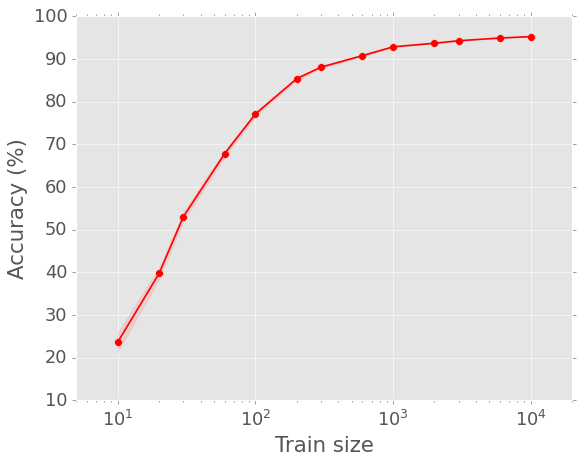

In [32]:
plot_with_err(100*acc, xdata = sample_size, axis = 1, ls = '-')
plt.scatter(sample_size, 100*np.mean(acc, axis = 1), c= 'r', marker = 'o', s = 50)
plt.xlim(5, 2e4)
plt.ylim(10, 100)
plt.xscale('log')
plt.xlabel('Train size')
plt.ylabel('Accuracy (%)')

In [10]:
def iterate(kdm):
    # np.random.seed(18800)
    n_train = 10000
    n_test = 10000
    npc = 10
    dt = 1
    
    n_im = n_train + n_test
    n_scan = (29-kdm)**2
    n_row = 29-kdm

    train_id = np.random.choice(range(60000), n_train, False)
    test_id  = np.random.choice(range(10000), n_test, False)

    trainX_raw  = data['trainX'][train_id]
    # trainXT = np.transpose(trainX_raw.reshape(-1, 28, 28), (0,2,1))
    trainY  = data['trainY'].reshape(-1)[train_id]

    testX_raw   = data['testX'][test_id]
    # testXT  = np.transpose(testX_raw.reshape(-1, 28, 28), (0,2,1))
    testY   = data['testY'].reshape(-1)[test_id]

    stream_raw = np.vstack((trainX_raw, testX_raw))
    stream = np.zeros((n_im, (29-kdm)**2, kdm**2))
    for i in range(n_im):
        stream[i,:] = kernel_scan(stream_raw[i].reshape(28,28), (kdm, kdm)).reshape(-1, kdm**2)

#     a, b = 1, -0.3
#     signals = a/255 * stream.reshape(-1, kdm**2) + b
#     length = signals.shape[0]

    Connectivity = connectivity__('200nw_1213junctions')
#     Connectivity = connectivity__('500nw_9905junctions')
    electrodes = np.random.choice(range(Connectivity.numOfWires), kdm**2 + 1, False)
    init_list = [inputPacker(run_MNIST, Connectivity, kdm, electrodes, stream[i:i+npc], i) for i in range(0, n_im, npc)]
    
    results = para_run(run_MNIST, init_list, dask_client = client, disable_tqdm = False)
    bb = np.stack(results).reshape(n_im, -1)
    curr_train = bb[:n_train, :] 
    curr_test = bb[n_train:, :]
    
    score = LDA_test(curr_train, trainY, curr_test, testY)
    return score

In [13]:
aa = iterate(13)

In [17]:
aa

0.98

In [11]:
Ks = [13]
iters = 4
accs = np.zeros((len(Ks), iters))

pbar = tqdm(total = len(Ks)*iters)
for i, kdm in enumerate(Ks):
    for j in range(iters):
        accs[i,j] = iterate(kdm)
        pbar.update(1)
pbar.close()

In [33]:
accs = np.zeros((6, 5))

In [34]:
accs[0] = np.array([0.9191, 0.9289, 0.9341, 0.9096, 0.9259])

In [35]:
accs[1] = np.array([0.9621,0.9621,0.9616,0.9623,0.9634])

In [36]:
accs[2] = np.array([0.9751,0.9771,0.9736,0.9746,0.975])

In [37]:
accs[3] = np.array([0.9759,0.9789,0.9791,0.9791,0.9786])

In [38]:
accs[4] = np.array([0.9761,0.9768,0.9788,0.9805,0.9796])

In [39]:
accs[5] = np.array([0.98,0.9769,0.9769,0.9774,0.9781])

Text(0, 0.5, 'Accuracy (%)')

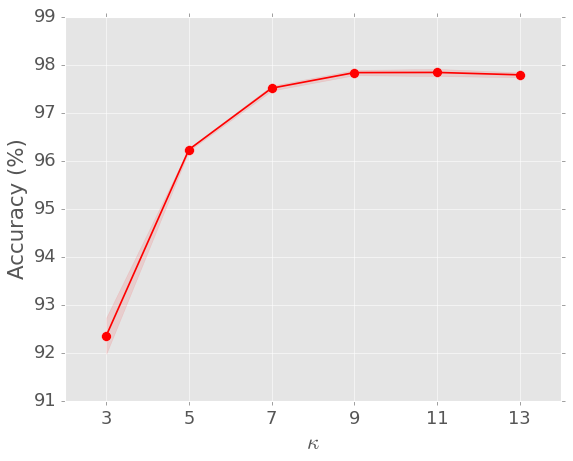

In [40]:
X = np.arange(3, 15, 2)
plot_with_err(100*accs,xdata = X, axis = 1)
plt.scatter(X, 100*np.mean(accs, axis = 1), c = 'r', s = 80)

plt.xticks(X)
plt.xlabel(r'$\kappa$')
plt.ylabel('Accuracy (%)')

Text(-0.15, 1.1, 'b')

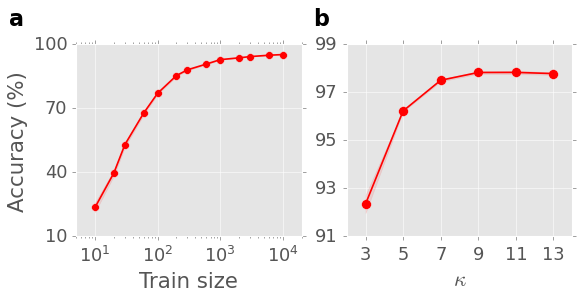

In [54]:
fig, axes = plt.subplots(1,2, figsize = (8, 3))

plot_with_err(100*acc, xdata = sample_size, axis = 1, ls = '-', ax = axes[0])
axes[0].scatter(sample_size, 100*np.mean(acc, axis = 1), c= 'r', marker = 'o', s = 50)
axes[0].set_xlim(5, 2e4)
axes[0].set_ylim(10, 100)
axes[0].set_xscale('log')
axes[0].set_yticks(np.arange(10, 101, 30))
axes[0].set_xlabel('Train size')
axes[0].set_ylabel('Accuracy (%)')


X = np.arange(3, 15, 2)
plot_with_err(100*accs,xdata = X, axis = 1, ax = axes[1])
axes[1].scatter(X, 100*np.mean(accs, axis = 1), c = 'r', s = 80)

axes[1].set_xticks(X)
axes[1].set_yticks(np.arange(91,100,2))

axes[1].set_xlabel(r'$\kappa$')

# axes[1].set_ylabel('Accuracy (%)')

from string import ascii_lowercase

axes[0].text(-0.3, 1.1, ascii_lowercase[0], transform=axes[0].transAxes, 
            size=20, weight='bold')

axes[1].text(-0.15, 1.1, ascii_lowercase[1], transform=axes[1].transAxes, 
            size=20, weight='bold')